# Baseline clustering models

In [32]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [2]:
df_main = pd.read_csv('main_df.csv')

In [9]:
df_main.head()

,Unnamed: 0,id,type,domain,scraped_at,url,authors,title,content,word_count,char_count,word_density,polarity,subjectivity,nouns,noun_chunks,entities,lemmas
0,0,7025856,political,dailykos.com,2017-11-27,https://www.dailykos.com/stories/2013/10/17/12...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",Classic Bachmann: Default avoided because Repu...,"Pssst, Michele, you just called yourself not a...",212,982,0.215666,0.154630,0.662191,"['adult', 'Pssst', 'adult', 'dice', 'adults', ...","['Michele', 'Republicans', 'default', 'intense...","['Pssst, Michele', 'Michele', 'Republicans', ""...","['Pssst', 'Michele', 'call', 'adult', 'pssst',..."
1,1,1966549,political,breitbart.com,2017-11-10,http://www.breitbart.com/jerusalem/2016/06/01/...,"Aaron Klein, Ali Waked","EXCLUSIVE: Hamas, Hezbollah Recruiting Fatah M...",TEL AVIV – The Israel Defense Forces on Monday...,367,1972,0.186011,0.046875,0.414167,"['city', 'refugee', 'camps', 'suspicion', 'pos...","['TEL AVIV', 'Monday', ' Palestinians', 'Nablu...","['TEL AVIV', 'The Israel Defense Forces', 'Pal...","['TEL', 'AVIV', 'Israel', 'Defense', 'Forces',..."
2,2,2628942,political,alternet.org,2017-11-13,https://www.alternet.org/environment/revealed-...,NaN,Revealed: FBI Terrorism Taskforce Investigatin...,Revealed: FBI Terrorism Taskforce Investigatin...,904,4889,0.184867,-0.039660,0.413462,"['leaders', 'movement', 'fear', 'terrorists', ...","['FBI Terrorism Taskforce', 'Standing Rock Act...","['FBI Terrorism Taskforce Investigating', 'Peg...","['reveal', 'FBI', 'Terrorism', 'Taskforce', 'i..."
3,3,3382763,political,dailykos.com,2017-11-18,https://www.dailykos.com/stories/2006/9/11/245...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",What's Condi Doing Today?,The Halifax Peace Coalition questioned the mot...,242,1221,0.198036,0.205208,0.407813,"['motivation', 'visit', 'relations', 'campaign...","['support', 'Afghanistan', 'Canadian troops', ...","['The Halifax Peace Coalition', 'Rice', 'Afgha...","['Halifax', 'Peace', 'Coalition', 'question', ..."
4,4,2034907,political,nationalreview.com,2017-11-10,http://www.nationalreview.com/corner/81541,Michael Ledeen,National Review,"Well, it’s very important, actually, because i...",337,1640,0.205363,0.127504,0.521075,"['hands', 'yellowcake', 'asset', 'president', ...","['Saddam', 'yellowcake', 'Niger', 'Seymour Her...","['Brits', 'Saddam', 'Niger', 'CIA', 'Seymour H...","['important', 'actually', 'explain', 'Brits', ..."


# TF-IDF + k-means

In [17]:
str_lists = [df_main['lemmas'].tolist()[i][1:-1].split(',') for i in range(len(df_main))]
lemmas_list = []
for i in range (len(str_lists)):
    lemmas_list.append(np.array([x.strip()[1:-1] for x in str_lists[i]]))
lemmas_list
lemmas_strings = [' '.join(sublist) for sublist in lemmas_list]
# limmit to 100 most frequent words
vectorizer = CountVectorizer(max_features=100)
X = vectorizer.fit_transform(lemmas_strings)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

## Choose the number of clusters

In [78]:
def plot_metrics(data, max_clusters):
    distortions = []
    silhouette_scores = []
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10, random_state=42)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        distortions.append(kmeans.inertia_) 
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].plot(range(2, max_clusters + 1), distortions, marker='o')
    axs[0].set_title('Elbow Method')
    axs[0].set_xlabel('Number of clusters')
    axs[0].set_ylabel('Total within-cluster sum of squares')
    axs[0].set_xticks(np.arange(1, max_clusters + 1))
    axs[1].plot(range(2, max_clusters+1), silhouette_scores, marker='o')
    axs[1].set_xlabel('Number of Clusters')
    axs[1].set_ylabel('Silhouette Score')
    axs[1].set_title('Silhouette Score')
    plt.show()

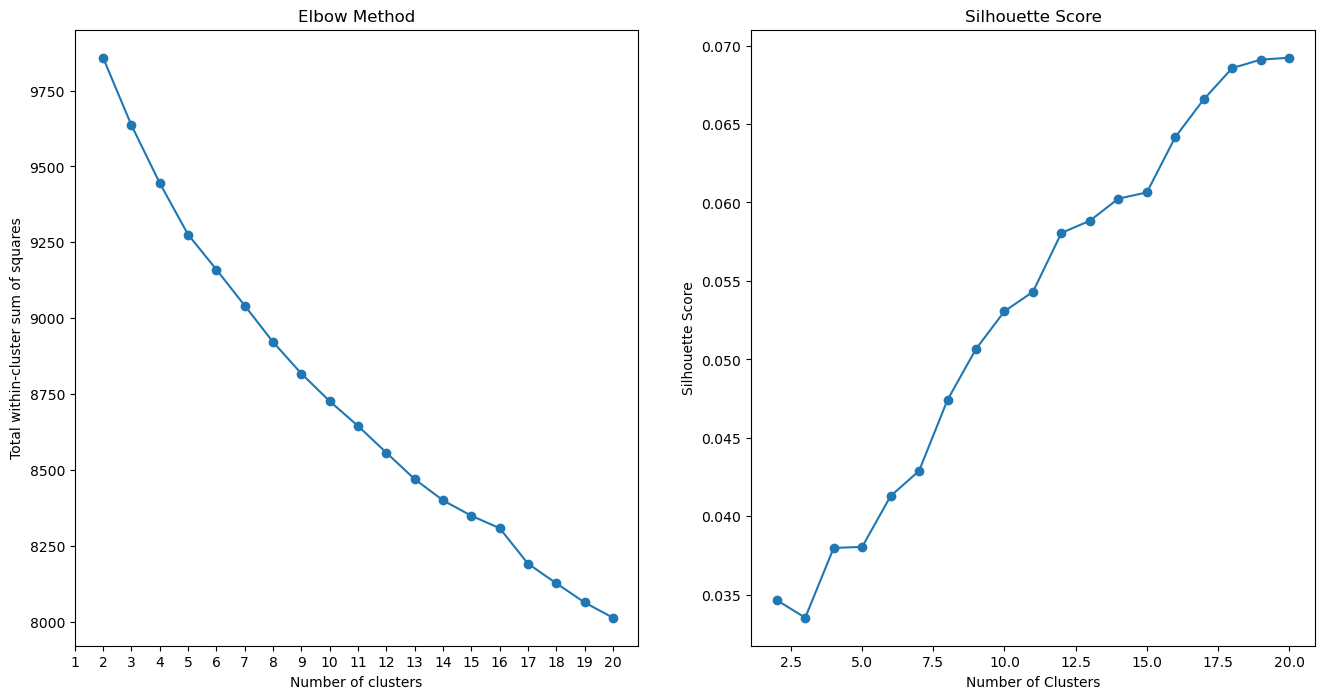

In [79]:
plot_metrics(X_tfidf, max_clusters=20)

## Evaluation

In [72]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10, init='k-means++')
kmeans.fit(X_tfidf.toarray())
labels_tf_idf = kmeans.labels_

In [73]:
print('Silhouette Score: {}'.format(silhouette_score(X_tfidf.toarray() , labels_tf_idf)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_tfidf.toarray() , labels_tf_idf)))

Silhouette Score: 0.03798813210205043
Calinski Harabasz Score: 293.8629144253833


## Visualization of clusters

In [58]:
def pca_plot(data, labels):
    pca = PCA(n_components=2)
    pca.fit(data)
    pca_data = pca.transform(data)
    plt.figure(figsize=(10, 10))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('PCA Plot')
    plt.show()

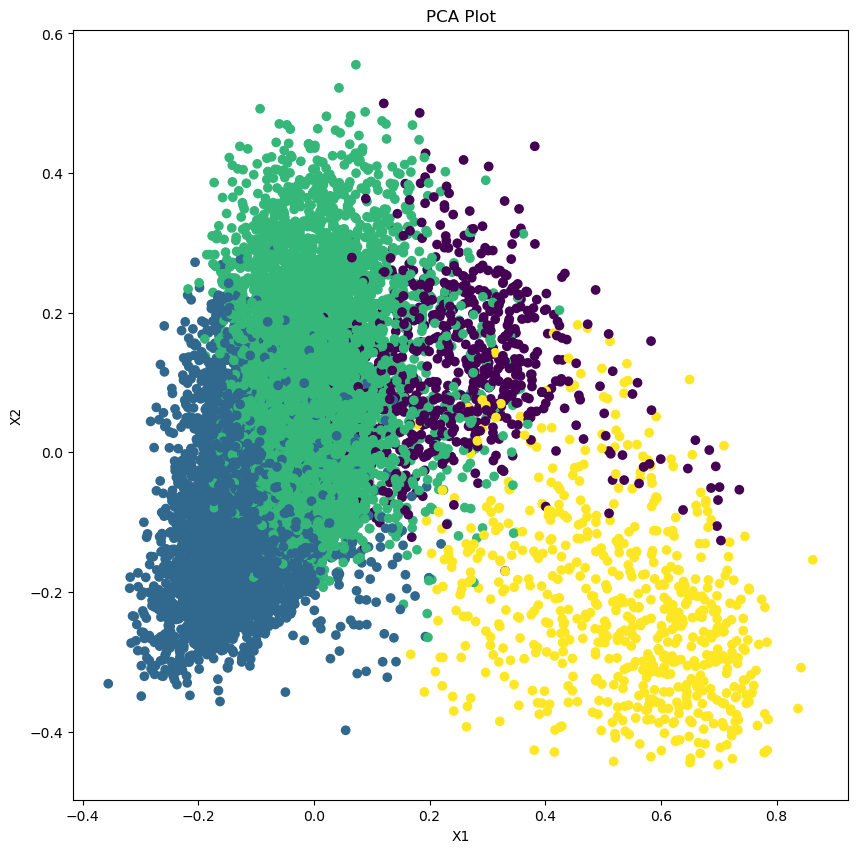

In [74]:
pca_plot(X_tfidf.toarray(), labels_tf_idf)

# Doc2Vec + k-means

In [88]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(lemmas_list)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

In [89]:
doc2vec_model.build_vocab(documents)
doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
document_vectors = [doc2vec_model.infer_vector(doc) for doc in lemmas_list]
X_doc2vec= np.array(document_vectors)

## Choose the number of clusters

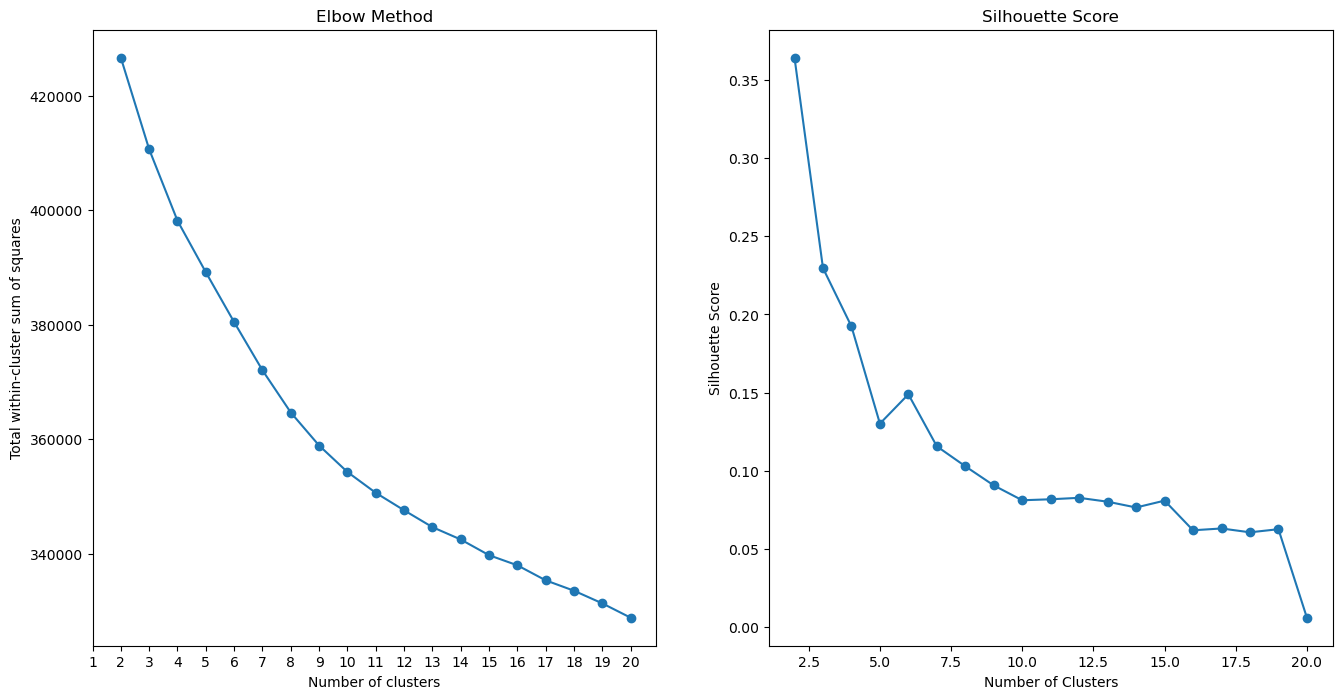

In [90]:
plot_metrics(X_doc2vec , max_clusters=20)

## Evaluation

In [91]:
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42,n_init=10, init='k-means++')
kmeans.fit(X_doc2vec)
labels_doc2vec = kmeans.labels_

In [92]:
print('Silhouette Score: {}'.format(silhouette_score(X_doc2vec, labels_doc2vec)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_doc2vec,labels_doc2vec)))

Silhouette Score: 0.14888393878936768
Calinski Harabasz Score: 449.97871005694714


## Visualization of clusters

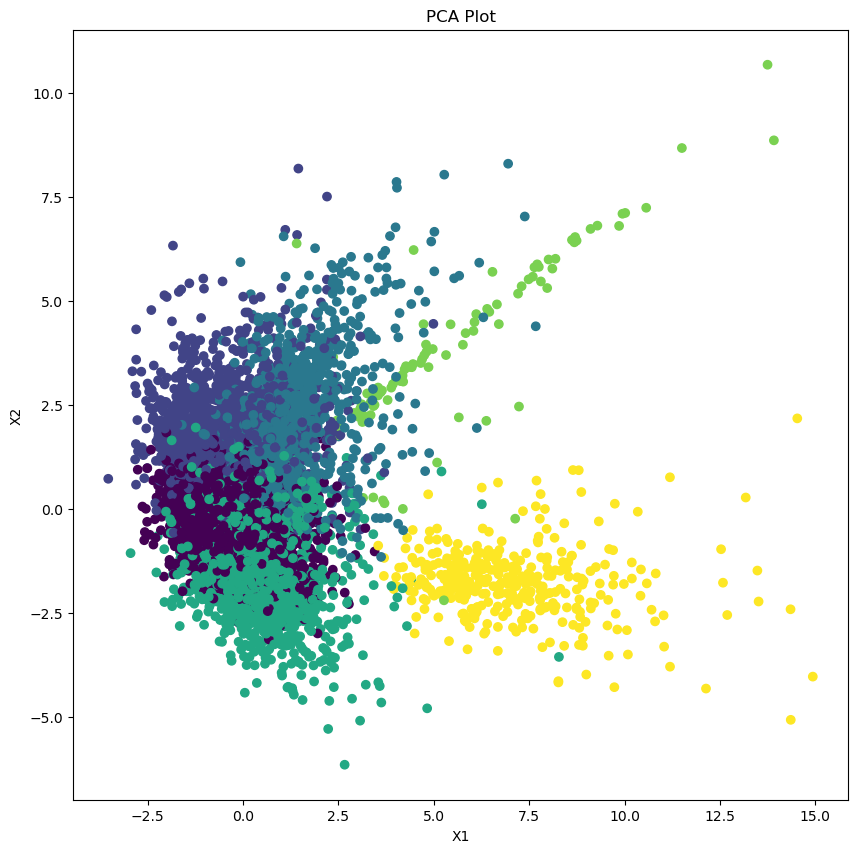

In [93]:
pca_plot(X_doc2vec, labels_doc2vec)

# LDA

In [22]:
dictionary = corpora.Dictionary(lemmas_list)
corpus = [dictionary.doc2bow(text) for text in lemmas_list]

## Choose the number of topics

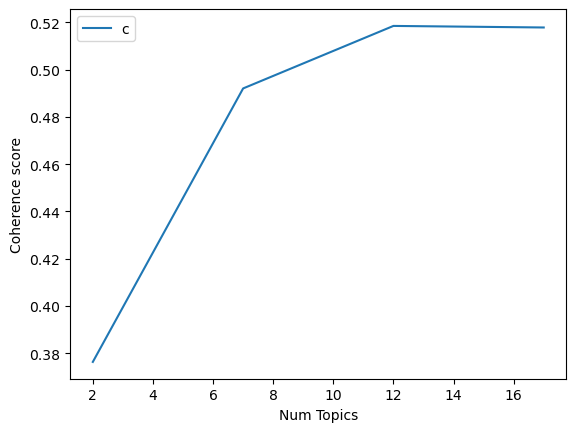

In [80]:
coherence_values = []
model_list = []
iters = range(2,22,5)
for num_topics in iters:
    model = LdaModel(corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=42,
                    update_every=1,
                    chunksize=100,
                    passes=10,
                    alpha='auto',
                    per_word_topics=True)
    model_list.append(model)
    coherencemodel =  gensim.models.CoherenceModel(model=model, texts=lemmas_list, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
plt.plot(iters, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Evaluation

In [81]:
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=12,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

In [82]:
import pprint
print("Topics examples:")
pprint.pprint(lda_model.print_topics(num_topics=2))

Topics examples:
[(4,
  '0.040*"photograph" + 0.030*"Putin" + 0.016*"aide" + 0.013*"spin" + '
  '0.011*"correspondent" + 0.010*"probe" + 0.010*"socialism" + 0.009*"Capitol" '
  '+ 0.007*"Sessions" + 0.005*"Mueller"'),
 (3,
  '0.013*"like" + 0.012*"time" + 0.012*"know" + 0.011*"people" + 0.009*"come" '
  '+ 0.009*"say" + 0.008*"thing" + 0.008*"go" + 0.008*"way" + 0.008*"think"')]


In [83]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=lemmas_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {lda_model.log_perplexity(corpus)}')  
print(f"Coherence score: {coherence_lda}")

Perplexity: -11.38260085366737
Coherence score: 0.5185415633080287


In [84]:
doc_topics = lda_model.get_document_topics(corpus)
num_docs = len(doc_topics)
doc_topics_csr = gensim.matutils.corpus2csc(doc_topics)
X_lda = doc_topics_csr.T.toarray()
major_topic = [np.argmax(arr) for arr in X_lda]
labels_lda = major_topic

In [85]:
print('Silhouette Score: {}'.format(silhouette_score(X_lda, labels_lda)))
print('Calinski Harabasz Score: {}'.format(calinski_harabasz_score(X_lda,labels_lda)))

Silhouette Score: 0.27784328438545186
Calinski Harabasz Score: 2676.167113920673


## Visualization of clusters

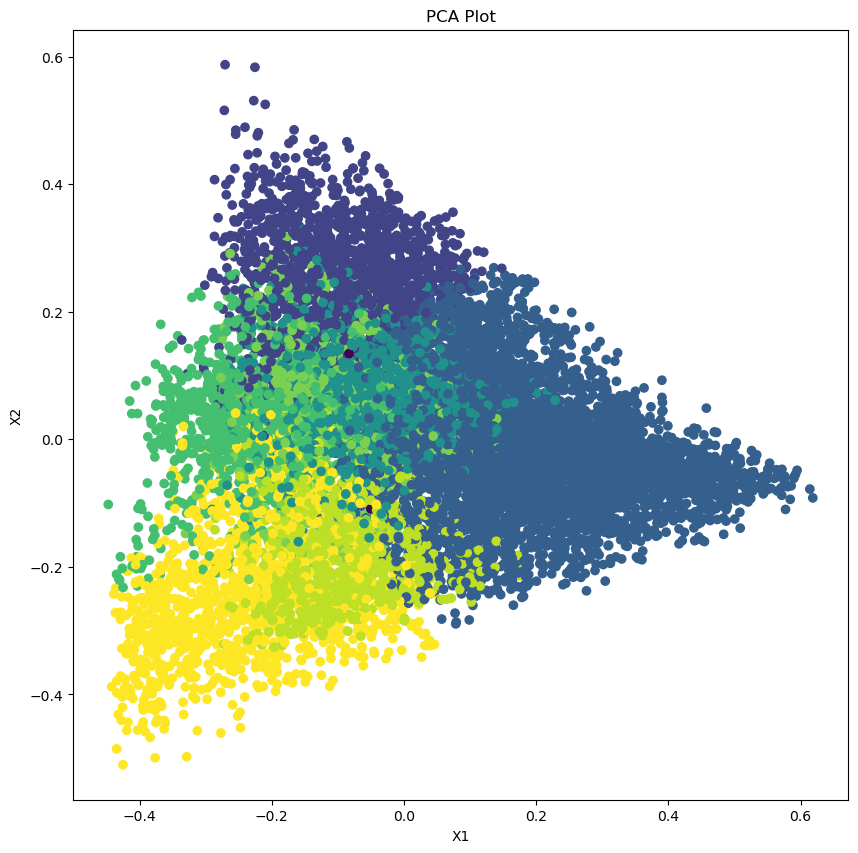

In [86]:
pca_plot(X_lda, labels_lda)